In this Jupyter Notebook we run the experiments of Section 6.1 for the MNIST dataset.

First of all, we have to import the required libraries as well as the data.

In [1]:
from keras.datasets import mnist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import random

#Load the dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
Y_train_alt=Y_train
X_train=X_train/X_train.sum(axis=(1,2))[:,None,None]
X_train=np.reshape(X_train,(np.size(X_train,0),28*28))
X_test=X_test/X_test.sum(axis=(1,2))[:,None,None]
X_test=np.reshape(X_test,(np.size(X_test,0),28*28))
Y_train=np.loadtxt('MNIST_D_train.gz', delimiter=',')
Y_test=np.loadtxt('MNIST_D_test.gz', delimiter=',')
bary0=np.loadtxt('BarycenterZero.gz', delimiter=',')
bary0=np.reshape(bary0,28*28)
B0f=np.loadtxt('MNIST_P_f.gz', delimiter=',')
B0g=np.loadtxt('MNIST_P_g.gz', delimiter=',')

# Compute the bias vector of the first hidden layer
bvectot=np.matmul(B0g,bary0)

2024-03-09 10:15:50.810973: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 10:15:50.848313: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 10:15:51.049566: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-09 10:15:51.051071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 10:15:52.565587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Experiment 6.1: We will first consider the relative error for 100 randomly drawn images of the test set and plot it against the number of potentials. Additionally, we plot the mean. 

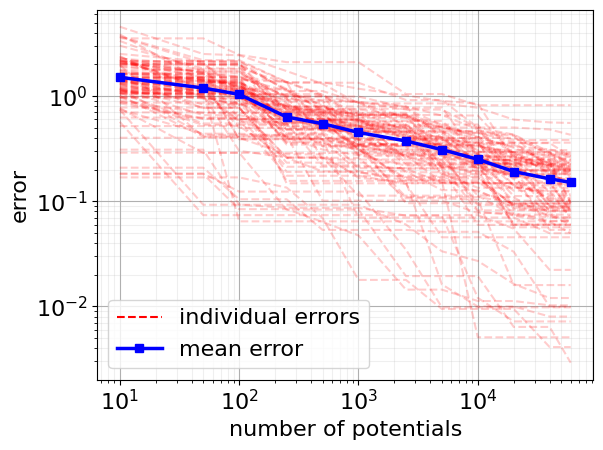

In [7]:
# Number of considered potentials
numpotvec=[10,50,100,250,500,1000,2500,5000,10000,20000,40000,60000]

# Draw randomly 100 images from the test set
idx2=random.sample(range(0,9999),100)
X_test_R=X_test[idx2,:]
Y_test_R=Y_test[idx2] 

# Randomly arrange the Kantorovich potentials 
idx=np.arange(B0f.shape[0])
np.random.shuffle(idx)
BS=B0f[idx,:]
bvecS=bvectot[idx]

# Compute the error of the 100 test measures for an increasing number of considered potentials
counter=0
errorlist=np.zeros((100,np.size(numpotvec)))
for numpot in numpotvec:
    Amat=BS[:numpot,:]
    bvec=bvecS[0:numpot]
    prod=np.dot(X_test_R,np.transpose(Amat))
    dist=prod+bvec
    maxval=dist.max(axis=1)
    err=(Y_test_R-maxval)/Y_test_R
    errorlist[:,counter]=err
    counter+=1

# Compute the mean for each value in numpotvec
distmean=np.mean(errorlist,axis=0)

# Generate the plot
fig, ax = plt.subplots()
plt.xlabel('number of potentials',fontsize=16)
plt.ylabel('error',fontsize=16)
plt.loglog(numpotvec,errorlist.T,'--r',alpha=0.2)
line = Line2D([0], [0], label='individual errors',color='r',linestyle='--')
line2, = plt.loglog(numpotvec,distmean,'-sb',linewidth=2.5,label="mean error")
ax.legend(handles=[line,line2],loc='lower left',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.grid(which='minor',alpha=0.2)
plt.show()

Experiment 6.2: We repeat more or less the experiment before. However, we only consider the mean error for all the elements in the test set. This procedure will then be repeated twenty times.  

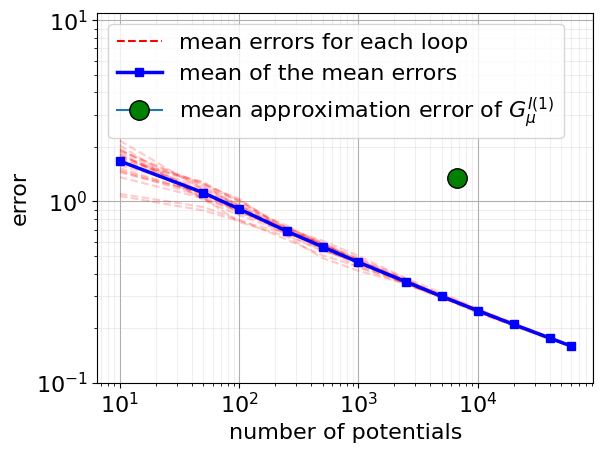

In [8]:
loops=20
errorlist=np.zeros((loops,np.size(numpotvec)))

# Run the procedure "loops" times
for i in range(loops):
    counter=0
    # Randomly arrange the Kantorovich potentials 
    idx=np.arange(B0f.shape[0])
    np.random.shuffle(idx)
    BS=B0f[idx,:]
    bvecS=bvectot[idx]
    # Compute the mean relative error of the entire test set for an increasing number of considered potentials
    for numpot in numpotvec:
        Amat=BS[:numpot,:]
        bvec=bvecS[0:numpot]
        prod=np.dot(X_test,np.transpose(Amat))
        dist=prod+bvec
        maxval=dist.max(axis=1)
        err=(Y_test-maxval)/Y_test
        mse=np.mean(err)
        errorlist[i,counter]=mse
        counter+=1

# Compute the mean for each value in numpotvec
distmean=np.mean(errorlist,axis=0)

# Compute the mean error when only considering the potentials corresponding to the digit "1"
idx=np.where(Y_train_alt==1)[0]
Amat=B0f[idx,:]
bvec=bvectot[idx]
prod=np.dot(X_test,np.transpose(Amat))
dist=prod+bvec
maxval=dist.max(axis=1)
err=(Y_test-maxval)/Y_test
omse=np.mean(err)
osize=np.size(idx)

# Generate the plots
fig, ax = plt.subplots()
ax.set_ylim([0.1, 10^1])
plt.xlabel('number of potentials',fontsize=16)
plt.ylabel('error',fontsize=16)
plt.loglog(numpotvec,errorlist.T,'--r',alpha=0.2)
line = Line2D([0], [0], label='mean errors for each loop',color='r',linestyle='--')
line2, = plt.loglog(numpotvec,distmean,'-sb',linewidth=2.5,label="mean of the mean errors")
onepoint, =plt.plot(osize, omse, marker="o", markersize=14, markeredgecolor="black", markerfacecolor="green",label="mean approximation error of $G_\mu^{I(1)}$")
ax.legend(handles=[line,line2,onepoint],loc='upper left',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.grid(which='minor',alpha=0.2)
plt.show()

Experiment 6.3 (Part 1): We repeat Experiment 6.1, however we replace the test by the training set. 

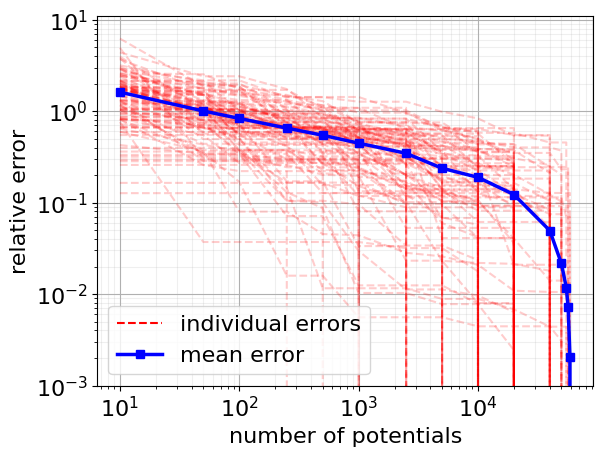

In [9]:
# Number of considered potentials
numpotvec=[10,50,100,250,500,1000,2500,5000,10000,20000,40000,50000,55000,57000,59000,60000]

# Draw randomly 100 elements from the training set
idx2=random.sample(range(0,59999),100)
X_test_R=X_train[idx2,:]
Y_test_R=Y_train[idx2]

# Randomly arrange the Kantorovich potentials 
idx=np.arange(B0f.shape[0])
np.random.shuffle(idx)
BS=B0f[idx,:]
bvecS=bvectot[idx]

# Compute the error of the 100 test measures (taken from the training set) for an increasing number of considered potentials
counter=0
errorlist=np.zeros((100,np.size(numpotvec)))
for numpot in numpotvec:
    Amat=BS[:numpot,:]
    bvec=bvecS[0:numpot]
    prod=np.dot(X_test_R,np.transpose(Amat))
    dist=prod+bvec
    maxval=dist.max(axis=1)
    err=(Y_test_R-maxval)/Y_test_R
    errorlist[:,counter]=err
    counter+=1

# Compute the mean for each value in numpotvec
distmean=np.mean(errorlist,axis=0)

#Plot the results
fig, ax = plt.subplots()
ax.set_ylim([0.001, 10^1])
plt.xlabel('number of potentials',fontsize=16)
plt.ylabel('relative error',fontsize=16)
plt.loglog(numpotvec,errorlist.T,'--r',alpha=0.2)
line = Line2D([0], [0], label='individual errors',color='r',linestyle='--')
line2, = plt.loglog(numpotvec,distmean,'-sb',linewidth=2.5,label="mean error")
ax.legend(handles=[line,line2],loc='lower left',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.grid(which='minor',alpha=0.2)
plt.show()

Experiment 6.3 (Part 2): We repeat Experiment 6.2, however we replace the test set by 10'000 random elements from the training set.

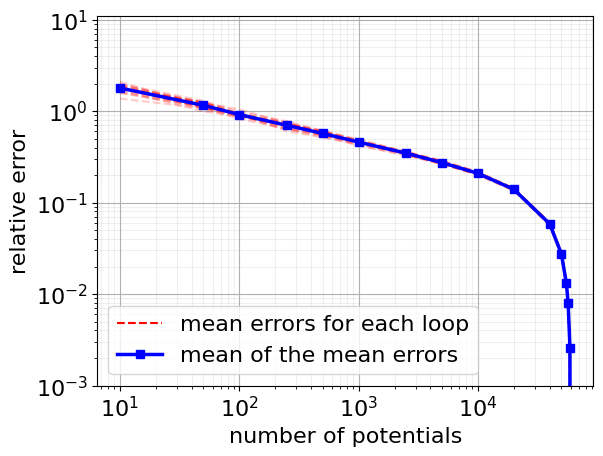

In [3]:
# Number of considered potentials
numpotvec=[10,50,100,250,500,1000,2500,5000,10000,20000,40000,50000,55000,57000,59000,60000]

loops=20
errorlist=np.zeros((loops,np.size(numpotvec)))

# Run the procedure "loops" times
for i in range(loops):
    # Randomly arrange the Kantorovich potentials 
    idx=np.arange(B0f.shape[0])
    np.random.shuffle(idx)
    idxS=np.random.choice(X_train.shape[0],10000,replace=False)
    X_test_R=X_train[idxS,:]
    Y_test_R=Y_train[idxS]
    BS=B0f[idx,:]
    bvecS=bvectot[idx]
    counter=0
    for numpot in numpotvec:
        Amat=BS[:numpot,:]
        bvec=bvecS[0:numpot]
        prod=np.dot(X_test_R,np.transpose(Amat))
        dist=prod+bvec
        maxval=dist.max(axis=1)
        err=(Y_test_R-maxval)/Y_test_R
        mse=np.mean(err)
        errorlist[i,counter]=mse
        counter+=1

# Compute the mean for each value in numpotvec
distmean=np.mean(errorlist,axis=0)

# Generate the plots
fig, ax = plt.subplots()
ax.set_ylim([0.001, 10^1])
plt.xlabel('number of potentials',fontsize=16)
plt.ylabel('relative error',fontsize=16)
plt.loglog(numpotvec,errorlist.T,'--r',alpha=0.2)
line = Line2D([0], [0], label='mean errors for each loop',color='r',linestyle='--')
line2, = plt.loglog(numpotvec,distmean,'-sb',linewidth=2.5,label="mean of the mean errors")
ax.legend(handles=[line,line2],loc='lower left',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid()
plt.grid(which='minor',alpha=0.2)
plt.show()